In [1]:
import os
import copy

##### use library

In [2]:
pwd

'/Users/A.IVA/Documents/jupyter_notebooks/coursera_and_blogs/pytorch/rl'

In [3]:
from src.m01_refactored import get_path, get_path_v2, plot_rho
import numpy as np

def get_dyn_obstacles_v1(t):
    if t % 3 == 0:
        return [(0,1), (1,1)]
    elif t % 3 == 1:
        return [(1,1), (2,1)]
    else:
        return [(0,1), (2,1)]


def get_dyn_obstacles_v2(t):
    if t % 3 == 0:
        return [(0,1), (1,1), (1,3), (2,3)]
    elif t % 3 == 1:
        return [(1,1), (2,1), (0,3), (2,3)]
    else:
        return [(0,1), (2,1), (0,3), (1,3)]

In [4]:
d0 = 3
d1 = 8
t_max = 15

params = {
    'd0': d0,
    'd1': d1,
    't_max': t_max,
    'alpha': 0.1,
    'gamma': 1,
    'max_iterations': 100000
}

reward_points_v1 = [
    {
        'pos': (0,3),
        't': np.arange(0,t_max),
        'reward': np.ones(shape=(t_max,))
    },
    {
        'pos': (1,3),
        't': np.arange(0,t_max),
        'reward': -6 * np.ones(shape=(t_max,)) 
    }
]

reward_points_v2 = [
    {
        'pos': (0,7),
        't': np.arange(0,t_max),
        'reward': np.ones(shape=(t_max,))
    },
    {
        'pos': (1,7),
        't': np.arange(0,t_max),
        'reward': -6 * np.ones(shape=(t_max,)) 
    },
]

imp_static = \
    [(-1, el) for el in range(d1)] + \
    [(d0, el) for el in range(d1)] + \
    [(el, -1) for el in range(d0)] + \
    [(el, d1) for el in range(d0)] + \
    [(1,4), (1,6)]

imp_all = [copy.deepcopy(imp_static) for el in range(t_max+1)]

for t in range(t_max+1):
    dyn_obstacles = get_dyn_obstacles_v2(t)
    imp_all[t].extend(dyn_obstacles)

In [5]:
result = get_path_v2(params=params,
                     impenetrable_points=imp_all,
                     reward_points=reward_points_v2)

tau = 14
tau = 13
tau = 12
tau = 11
tau = 10
tau = 9
tau = 8
tau = 7
tau = 6
tau = 5
tau = 4
tau = 3
tau = 2
tau = 1
tau = 0


In [7]:
# result = get_path(params=params,
#                   impenetrable_points=imp_all,
#                   reward_points=reward_points_v2)

In [6]:
# result['rhos'][0][0,2] = np.array([1, 0 ,0 ,0 ,0])
# result['rhos'][2][(1,2)]

In [16]:
import copy
import itertools
import numpy as np
from matplotlib import pyplot as plt
from typing import List, Tuple


def plot_rho(V, probabilities, impenetrable_points, d0, d1):
    fig = plt.figure(figsize=(1.5 * (d1 + 1), 1.5 * d0))

    ax = fig.add_subplot(1, 1, 1, xticks=np.arange(d1), yticks=np.arange(d0))
    plt.imshow(V, interpolation='none', aspect='auto', cmap='RdYlGn')
    plt.colorbar()
    arrows = [u'\u26ab', '\u25b2', '\u25bc', '\u25b6', '\u25c0']

    for (i, j), v in np.ndenumerate(np.around(V, 2)):
        label = ''
        if (i, j) not in impenetrable_points:
            if v < 0.01:
                label = "x\n "
            else:
                probability_vec = probabilities[(i, j)]
                direction = arrows[np.argmax(probability_vec)]
                prob = np.max(np.round(probability_vec, 2))
                label = f"{direction}\n{prob}"

        plt.gca().text(j, i, label, ha='center', va='center')

    plt.show()
    return fig

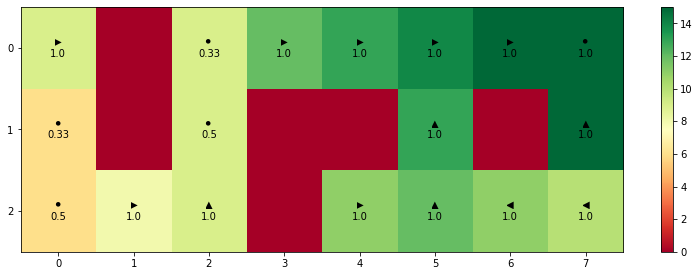

In [19]:
t=0
fig = plot_rho(V=result['v_stars'][t], 
             probabilities=result['rhos'][t], 
             impenetrable_points=imp_all[t], 
             d0=d0, 
             d1=d1)

fig.savefig('probs_a.png', transparent=True)

In [6]:
t=0
print(t)
print(np.round(result['rhos'][t][(1,2)], 3))
print(np.round(result['rhos'][t][(1,0)], 3))
print(np.round(result['rhos'][t][(2,0)], 3))
print(np.round(result['rhos'][t][(0,2)], 3))

t=1
print('\n\n', t)
print(np.round(result['rhos'][t][(0,0)], 3))
print(np.round(result['rhos'][t][(1,0)], 3))


t=2
print('\n\n', t)
print(np.round(result['rhos'][t][(1,2)], 3))
print(np.round(result['rhos'][t][(2,2)], 3))

0
[0.5 0.5 0.  0.  0. ]
[0.333 0.333 0.333 0.    0.   ]
[0.5 0.5 0.  0.  0. ]
[0.333 0.    0.333 0.    0.333]


 1
[0.5 0.  0.5 0.  0. ]
[0.333 0.333 0.    0.333 0.   ]


 2
[0.333 0.333 0.333 0.    0.   ]
[0.5 0.5 0.  0.  0. ]


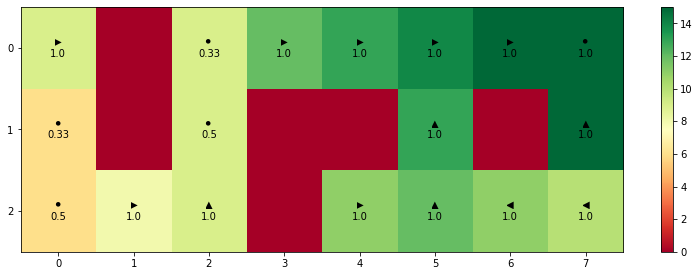

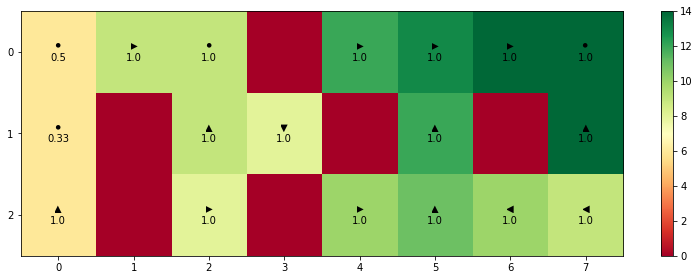

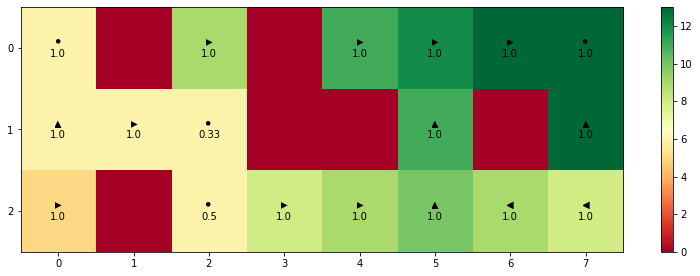

In [7]:
for t in range(3):  #range(t_max):
    plot_rho(V=result['v_stars'][t], 
             probabilities=result['rhos'][t], 
             impenetrable_points=imp_all[t], 
             d0=d0, 
             d1=d1)

##### alg at problematic place

In [9]:
from src.m01_refactored import *

In [11]:
result.keys()

dict_keys(['v_stars', 'rhos', 'rewards', 'masks'])

In [14]:
rewards = result['rewards']
masks = result['masks']
v_stars = result['v_stars']

In [35]:
tau = 0
xi = (1,2)

reward = rewards[tau]  # rewards[tau] refers to reward collected at tau+1
mask = masks[tau][xi]
v_star = np.zeros(shape=(d0, d1)) if tau == t_max - 1 else v_stars[tau + 1]

lam, min_val, info = fmin_l_bfgs_b(func=neg_v_st_new,
                                   x0=np.array([0., 0., 0., 0., 0.]),
                                   fprime=neg_grad_v_st_new,
                                   args=[np.round(v_star,4), mask, xi, reward],
                                   factr=1e5,  # 1e7
                                   pgtol=1e-9,  # 1e-5
                                   maxfun=1000000,  # 15000
                                   maxiter=1000000)  # 15000



In [16]:
info

{'grad': array([-8.02709613e-10, -7.25636160e-10,  7.64172845e-10,  7.64172845e-10,
        -0.00000000e+00]),
 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'funcalls': 26,
 'nit': 25,
 'warnflag': 0}

In [36]:
lam

array([ 10.14919975,  10.14919975, -10.1491999 , -10.1491999 ,
         0.        ])

In [37]:
get_rho(lam, mask)

array([4.99999999e-01, 4.99999999e-01, 7.64692881e-10, 7.64692881e-10,
       0.00000000e+00])

In [19]:
mask

array([ True,  True,  True,  True, False])

In [20]:
reward

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -6.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [27]:
print(np.round(v_star,8))

[[ 5.99999999  8.99999999  8.99999999  0.         11.99999999 12.99999999
  13.99999999 13.99999999]
 [ 5.99999999  0.          8.99999999  7.99999999  0.         11.99999999
   0.         13.99999999]
 [ 5.99999999  0.          7.99999999  0.          9.99999999 10.99999999
   9.99999999  8.99999999]]


In [33]:
args=[np.round(v_star,4), mask, xi, reward]
neg_grad_v_st_new(lam, *args)                         

array([-7.90695215e-10, -7.37650542e-10,  7.64172845e-10,  7.64172845e-10,
       -0.00000000e+00])

In [34]:
neg_grad_v_st_new(np.round(lam, 0), *args)

array([-1.03057727e-09, -1.03057727e-09,  1.03057681e-09,  1.03057681e-09,
       -0.00000000e+00])

In [31]:
lam

array([ 10.18395928,  10.11451739, -10.14923895, -10.14923895,
         0.        ])

##### trajectory explorer

In [8]:
def traj_realization(rhos, t_max, x_init=(2,0), x_final=(0,7)):

    n_steps = 0
    t = 0
    x, x_new = x_init, None
    steps=[x]

    while x_new != x_final and t < t_max:

        move_prob = rhos[t][x]
        move_cumulative_prob = np.cumsum(move_prob)

        rv = np.random.rand()
        mask = rv < move_cumulative_prob
        action = np.argmax(mask)

        if action == 0:
            x_new = x
        elif action == 1:
            x_new = (x[0]-1, x[1])
        elif action == 2:
            x_new = (x[0]+1, x[1])
        elif action == 3:
            x_new = (x[0], x[1]+1)
        else:
            x_new = (x[0], x[1]-1)

        x = x_new
        t += 1
        n_steps += 1
        steps.append(x)

    return n_steps, steps

In [9]:
rhos = result['rhos']

In [10]:
n_steps_collection = [traj_realization(rhos, t_max, x_init=(2,0), x_final=(0,7)) for _ in range(100000)]
n_steps_collection = map(lambda x: x[0], n_steps_collection)
n_steps_collection = list(n_steps_collection)
set(n_steps_collection)

{10}

In [11]:
n_steps_collection = [traj_realization(rhos, t_max, x_init=(2,0), x_final=(0,7)) for _ in range(10000)]
n_steps_collection = map(lambda x: str(x[1]), n_steps_collection)
n_steps_collection = list(n_steps_collection)

unique, counts = np.unique(n_steps_collection, return_counts=True)
print(np.asarray((unique, counts)).T)

[['[(2, 0), (1, 0), (0, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '1626']
 ['[(2, 0), (1, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '1699']
 ['[(2, 0), (1, 0), (1, 1), (1, 2), (0, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '813']
 ['[(2, 0), (1, 0), (1, 1), (1, 2), (1, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '846']
 ['[(2, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '5016']]


In [109]:
unique

array(['[(2, 0), (1, 0), (0, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]',
       '[(2, 0), (1, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]',
       '[(2, 0), (1, 0), (1, 1), (1, 2), (0, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]',
       '[(2, 0), (1, 0), (1, 1), (1, 2), (1, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]',
       '[(2, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'],
      dtype='<U88')

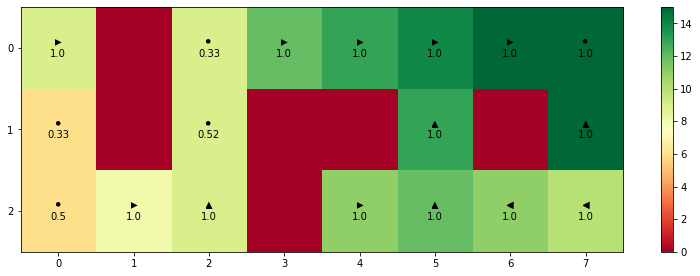

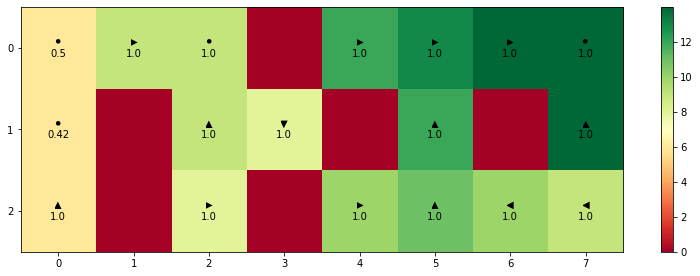

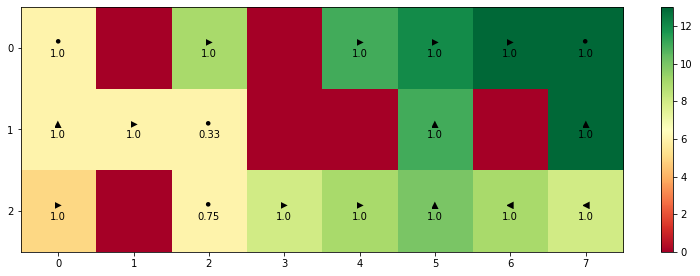

In [6]:
for t in range(3):  #range(t_max):
    plot_rho(V=result['v_stars'][t], 
             probabilities=result['rhos'][t], 
             impenetrable_points=imp_all[t], 
             d0=d0, 
             d1=d1)

##### use the L-BFGS-B algorithm

In [38]:
from scipy.optimize import fmin_l_bfgs_b

In [43]:
def f(x):    
    return x**2 -2*x + 1

def fprime(x):
    return 2*(x - 1)


x, min_val, info = fmin_l_bfgs_b(func=f, 
                                 x0=7, 
                                 fprime=fprime,
                                 epsilon=1e-6,
                                 maxiter=15000)

In [52]:
# vector inputs are allowed

def f(x):
    return x @ x + 11

def fprime(x):
    return 2 * x

x, min_val, info = fmin_l_bfgs_b(func=f, 
                                 x0=np.array([8.,4.]), 
                                 fprime=fprime,
                                 epsilon=1e-6,
                                 maxiter=15000)

In [72]:
# vector inputs are allowed

def f(x, rmat, mm=9):
    return x @ x + rmat[(1,1)] + mm

def fprime(x, rmat):
    return 2 * x

x, min_val, info = fmin_l_bfgs_b(func=f, 
                                 x0=np.array([8.,4.]), 
                                 fprime=fprime,
                                 args=[tmp],
                                 epsilon=1e-6,
                                 maxiter=15000)

In [73]:
x

array([-4.44089210e-15, -2.22044605e-15])

In [75]:
min_val

12.0

In [83]:
tmp = np.array([0., 0., 0., 0., 0.])[[True, True, False, True, False]]

In [84]:
tmp

array([0., 0., 0.])

In [82]:
tmp[[True, True, False, True, False]]

array([0., 0., 0.])

In [71]:
tmp = np.arange(0,4,1).reshape(-1,2)
print(tmp)
print(f(x=np.array([1,2]), rmat=tmp))
print(f(x=np.array([1,2]), **{'rmat': tmp}))

[[0 1]
 [2 3]]
8
8
